### MFIN7034 Problem Set 2 – Factor and Portfolio Analysis

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [79]:
port_ret_df = pd.read_csv('data\portfolio_return_series.csv');
port_ret_df['YearMonth'] = pd.to_datetime(port_ret_df['YearMonth'])
port_ret_df.set_index('YearMonth', inplace=True)
port_ret_df = port_ret_df.apply(lambda x: x / 100)
port_ret_df.columns = port_ret_df.columns.str.strip()

In [80]:
port_ret_df.head()

,Small-cap growth,Small-cap value,Large-cap growth,Large-cap value,MKT
YearMonth,,,,,
1982-01-01,-0.0487,-0.0084,-0.0189,0.0043,-0.0004
1982-02-01,-0.0747,-0.0074,-0.0741,-0.0195,0.0018
1982-03-01,-0.0219,0.0149,-0.0196,0.0193,0.0247
1982-04-01,0.0653,0.0413,0.0573,0.0258,0.0526
1982-05-01,-0.0357,-0.0096,-0.0347,-0.0245,0.0010


#### 1.1 Certainty Equivalent Rate of Return

The value of ( A ) can be calculated using the formula:

$$
A = \frac{E(R_m) - R_f}{w \cdot \text{Var}(R_m)} 
$$

where:
- $E(R_m)$ is the expected return of the market.
- $R_f$ is the risk-free rate.
- $w$  is the weight in the market index.
- $\text{Var}(R_m)$ is the variance of the market return.

Calculated A: 5.81


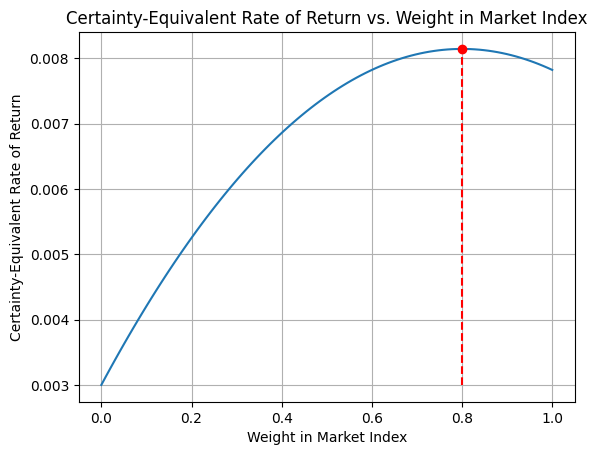

In [ ]:
market_returns = port_ret_df['MKT']

# expected return and variance
E_Rm = market_returns.mean()
Var_Rm = market_returns.var()

R_f = 0.003  # Risk-free rate per month in decimal
w_optimal = 0.8  # Current allocation in the market index

A = (E_Rm - R_f) / (w_optimal * Var_Rm)
print(f"Calculated A: {A:.2f}")

# Plotting the certainty-equivalent rate of return
weights = np.linspace(0, 1, 100)
U_values = weights * E_Rm + (1 - weights) * R_f - 0.5 * A * (weights**2) * Var_Rm

plt.plot(weights, U_values)
plt.plot([0.8, 0.8], [0.003, U_values[80]], color='r', linestyle='--')
plt.scatter(0.8, U_values[80], color='red', zorder=5, label='Optimal Point')
plt.xlabel('Weight in Market Index')
plt.ylabel('Certainty-Equivalent Rate of Return')
plt.title('Certainty-Equivalent Rate of Return vs. Weight in Market Index')
plt.grid(True)
plt.show()

#### 1.2 Efficient Frontier and Tangent Portfolio

In [5]:
import numpy as np

# generate weights ranging from -0.5 to 1.5, that sum to 1
# returns a numpy array
def generate_weights(n):
    S_x = (1 + 0.5 * n) / 2.0
    x = []
    remaining_sum = S_x
    for i in range(n):
        variables_left = n - i
        lower = max(0.0, remaining_sum - (variables_left - 1) * 1.0)
        upper = min(1.0, remaining_sum)
        xi = np.random.uniform(low=lower, high=upper)
        x.append(xi)
        remaining_sum -= xi
        
    # Convert x to weights in the range [-0.5, 1.5]
    weights = [2 * xi - 0.5 for xi in x]
    current_total = sum(weights)
    weights[-1] += (1.0 - current_total)
    if weights[-1] < -0.5 or weights[-1] > 1.5:
        discrepancy = 1.0 - sum(weights)
        adjustment = discrepancy / n
        weights = [w + adjustment for w in weights]

    return np.array(weights)

In [6]:
# Function to simulate portfolios
def simulate_portfolios(returns, R_f=0.003, num_portfolios=10000, constraints=None):
    num_assets = returns.shape[1]
    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in tqdm(range(num_portfolios)):
        if constraints == 'long_only':
            weights = np.random.random(num_assets)
            weights /= np.sum(weights)
        elif constraints == 'bounded':
            """
            # Weight Normalization (AI agent report point): 
            # Original code normalized bounded 
            # weights without ensuring the sum is non-zero, 
            # potentially creating NaN values
            weights = np.random.uniform(-0.5, 1.5, num_assets)
            weights /= np.sum(weights)
            """
            # weights from -0.5 to 1.5
            weights = generate_weights(num_assets)

        weights_record.append(weights)
        portfolio_return = np.sum(weights * returns.mean())
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
        results[0,i] = portfolio_return
        results[1,i] = portfolio_std_dev
        results[2,i] = (portfolio_return - R_f) / portfolio_std_dev

    return results, weights_record

# Function to plot the efficient frontier
def plot_efficient_frontier(results, weights_record, returns, R_f=0.003):
    max_sharpe_idx = np.argmax(results[2])
    max_sharpe_return = results[0, max_sharpe_idx]
    max_sharpe_std_dev = results[1, max_sharpe_idx]
    max_sharpe_weights = weights_record[max_sharpe_idx]

    # Calculate tangent line parameters
    slope = (max_sharpe_return - R_f) / max_sharpe_std_dev
    x_tangent = np.linspace(0, max_sharpe_std_dev * 1.5, 100)
    y_tangent = R_f + slope * x_tangent

    plt.figure(figsize=(10, 7))
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o', s=10, alpha=0.3)
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(max_sharpe_std_dev, max_sharpe_return, c='red', marker='*', s=500, label='Tangent Portfolio')
    plt.plot(x_tangent, y_tangent, '--', c='orange', label='Capital Market Line')
    # Set dynamic axis limits with 10% padding
    x_padding = 0.1 * np.max(results[1,:])
    y_padding = 0.1 * np.max(results[0,:])
    plt.xlim(max(0, np.min(results[1,:]) - x_padding), 
             np.max(results[1,:]) + x_padding)
    plt.ylim(np.min(results[0,:]) - y_padding, 
             np.max(results[0,:]) + y_padding)
    plt.title(f'Efficient Frontier for Scenario')
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Return')
    plt.legend(labelspacing=0.8)
    plt.show()

    print(f'Tangent Portfolio Weights:')
    for i, col in enumerate(returns.columns):
        print(f"{col}: {max_sharpe_weights[i]:.2f}")

    print(f'Sharpe Ratio: {slope:.2f}')
    certainty_equivalent_return = max_sharpe_return - 0.5 * A * (max_sharpe_std_dev ** 2)
    print(f'Certainty Equivalent Rate of Return: {certainty_equivalent_return:.4f}')

100%|██████████| 10000/10000 [00:02<00:00, 3476.39it/s]


==================== Scenarios 1====================


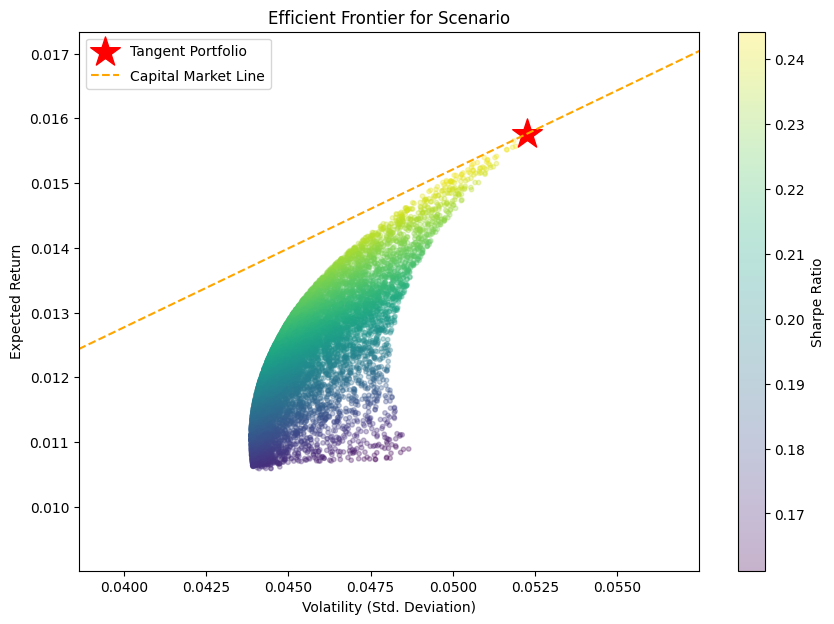

Tangent Portfolio Weights:
MKT: 0.98
Large-cap growth: 0.01
Large-cap value: 0.00
Sharpe Ratio: 0.24
Certainty Equivalent Rate of Return: 0.0078




100%|██████████| 10000/10000 [00:03<00:00, 3307.30it/s]


==================== Scenarios 2====================


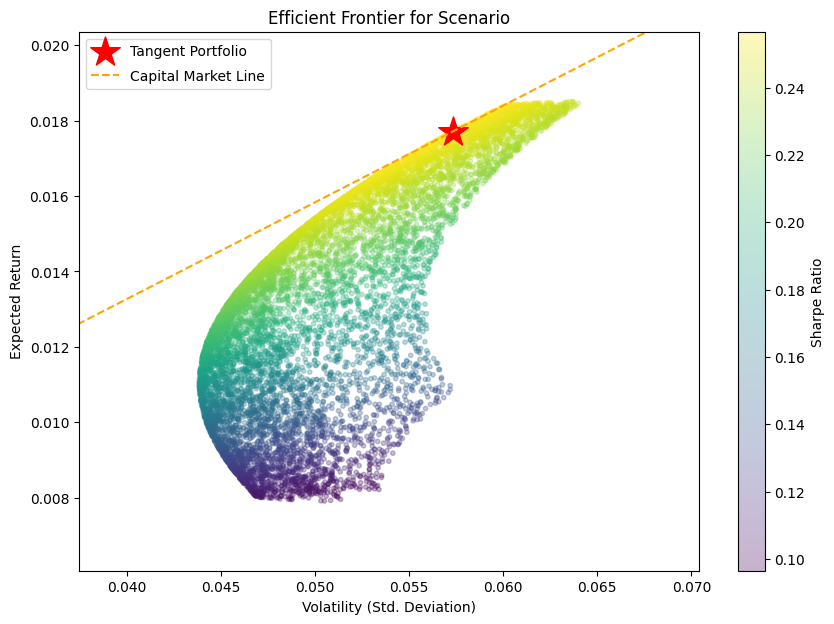

Tangent Portfolio Weights:
MKT: 1.37
Large-cap growth: 0.13
Large-cap value: -0.50
Sharpe Ratio: 0.26
Certainty Equivalent Rate of Return: 0.0082




100%|██████████| 100000/100000 [00:30<00:00, 3319.82it/s]


==================== Scenarios 3====================


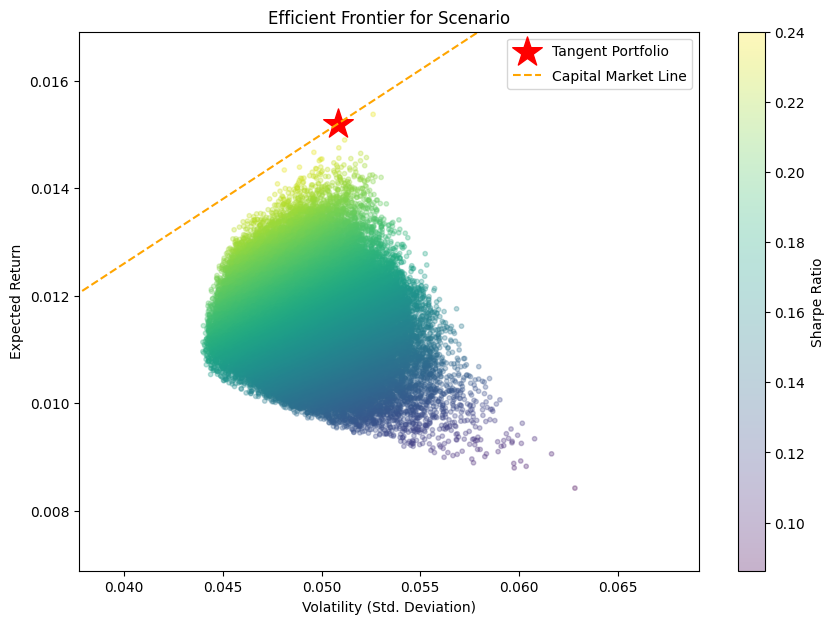

Tangent Portfolio Weights:
MKT: 0.87
Large-cap growth: 0.08
Large-cap value: 0.03
Small-cap growth: 0.01
Small-cap value: 0.01
Sharpe Ratio: 0.24
Certainty Equivalent Rate of Return: 0.0077




100%|██████████| 100000/100000 [00:30<00:00, 3292.82it/s]


==================== Scenarios 4====================


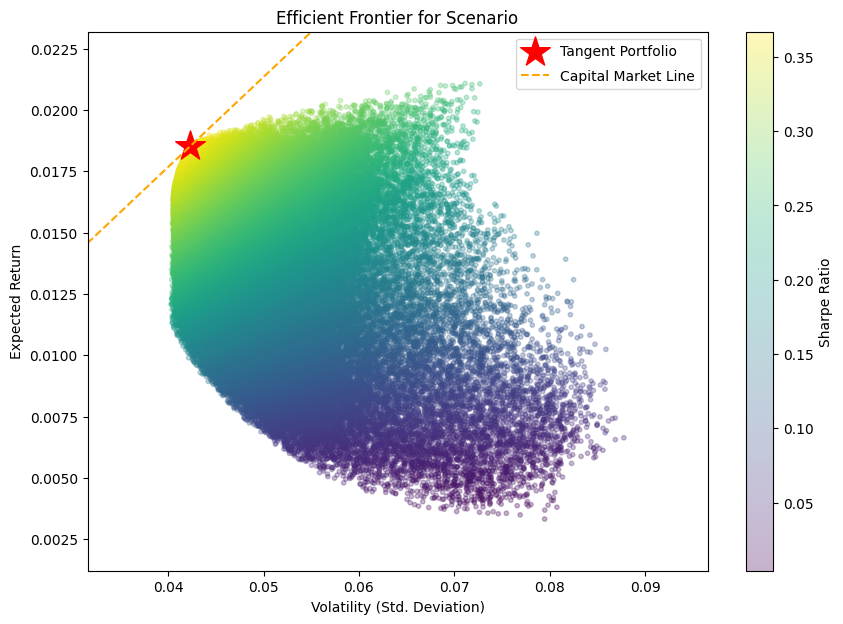

Tangent Portfolio Weights:
MKT: 1.49
Large-cap growth: 0.79
Large-cap value: -0.28
Small-cap growth: -0.50
Small-cap value: -0.50
Sharpe Ratio: 0.37
Certainty Equivalent Rate of Return: 0.0133




In [7]:
scenarios = [
    ('long_only', ['MKT', 'Large-cap growth', 'Large-cap value']),
    ('bounded', ['MKT', 'Large-cap growth', 'Large-cap value']),
    ('long_only', ['MKT', 'Large-cap growth', 'Large-cap value', 'Small-cap growth', 'Small-cap value']),
    ('bounded', ['MKT', 'Large-cap growth', 'Large-cap value', 'Small-cap growth', 'Small-cap value'])
]

for i, (constraint, assets) in enumerate(scenarios, 1):
    selected_returns = port_ret_df[assets]
    num_simulation = 10000
    # because more assets, need to run more simulation
    if i >= 3:
        num_simulation *= 10
    results, weights_record = simulate_portfolios(selected_returns, num_portfolios=num_simulation, constraints=constraint)
    print('='*20 + ' Scenarios ' + str(i) + '='*20)
    plot_efficient_frontier(results, weights_record, selected_returns)
    print('\n')

#### 2.1 Factor Zoo Deeper Explorations - Trials

In [4]:
'''
Value Factors
['ceqq',  # Common Equity (Book Value)
 'seqq',  # Shareholders' Equity
 'prccq', # Price Close (for Market Equity calculation)
 'epspxq',# EPS (Basic) Excl. Extra Items
 'dvpsxq',# Dividends per Share Excl. Special
 'mibq']  # Minority Interest

Profitability/Quality Factors
['revtq',  # Revenue
 'oiadpq', # Operating Income After Depreciation
 'saleq',  # Sales
 'gpq',    # Gross Profit (if exists)
 'cogsq',  # Cost of Goods Sold
 'xsgaq']  # SG&A Expense

Investment/Growth Factors
['capxy',  # Capital Expenditures
 'ivstq',  # Short-Term Investments
 'ppentq', # Property, Plant & Equipment
 'atq',    # Total Assets (for Asset Growth)
 'cheq']   # Cash & Equivalents

Liquidity/Risk Factors
['actq',   # Current Assets
 'lctq',   # Current Liabilities
 'dlttq',  # Long-Term Debt
 'prchq',  # Price High (for volatility measures)
 'prclq']  # Price Low
'''

"\nValue Factors\n['ceqq',  # Common Equity (Book Value)\n 'seqq',  # Shareholders' Equity\n 'prccq', # Price Close (for Market Equity calculation)\n 'epspxq',# EPS (Basic) Excl. Extra Items\n 'dvpsxq',# Dividends per Share Excl. Special\n 'mibq']  # Minority Interest\n\nProfitability/Quality Factors\n['revtq',  # Revenue\n 'oiadpq', # Operating Income After Depreciation\n 'saleq',  # Sales\n 'gpq',    # Gross Profit (if exists)\n 'cogsq',  # Cost of Goods Sold\n 'xsgaq']  # SG&A Expense\n\nInvestment/Growth Factors\n['capxy',  # Capital Expenditures\n 'ivstq',  # Short-Term Investments\n 'ppentq', # Property, Plant & Equipment\n 'atq',    # Total Assets (for Asset Growth)\n 'cheq']   # Cash & Equivalents\n\nLiquidity/Risk Factors\n['actq',   # Current Assets\n 'lctq',   # Current Liabilities\n 'dlttq',  # Long-Term Debt\n 'prchq',  # Price High (for volatility measures)\n 'prclq']  # Price Low\n"

In [4]:
fund_full_df = pd.read_csv('data/fundamental_quarterly.csv')
fund_full_df.head()

C:\Users\Betty\AppData\Local\Temp\ipykernel_27068\3290292102.py:1: DtypeWarning: Columns (2,17,19,20,24,25,27,32,33,37,39,40,41,42,654,655,656,657,661,663,671,675,676,681,682,686) have mixed types. Specify dtype option on import or set low_memory=False.
  fund_full_df = pd.read_csv('data/fundamental_quarterly.csv')


,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyearq,...,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
0,1004,P,1,LU,54594,20000,1972-04-24,E,1998-08-31,1998,...,1,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,NaN,1972-04-24
1,1004,P,1,LU,54594,20000,1972-04-24,E,1998-11-30,1998,...,1,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,NaN,1972-04-24
2,1004,P,1,LU,54594,20000,1972-04-24,E,1999-02-28,1998,...,1,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,NaN,1972-04-24
3,1004,P,1,LU,54594,20000,1972-04-24,E,1999-05-31,1998,...,1,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,NaN,1972-04-24
4,1004,P,1,LU,54594,20000,1972-04-24,E,1999-08-31,1999,...,1,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,NaN,1972-04-24


In [5]:
# drop columns with more than 15% missing values
threshold = 0.15
null_percentage = fund_full_df.isnull().sum() / len(fund_full_df)
columns_to_drop = null_percentage[null_percentage > threshold].index
fund_df = fund_full_df.drop(columns=columns_to_drop)

# drop columns that are not numeric except LPERMNO and datadate
numeric_cols = fund_df.select_dtypes(include=['number']).columns.tolist()
numeric_cols.append('datadate')
fund_df = fund_df[numeric_cols]
fund_df.head()

,GVKEY,LPERMNO,LPERMCO,fyearq,fqtr,fyr,ajexq,ajpq,currtrq,srcq,...,fyrc,ggroup,gind,gsector,gsubind,naics,priusa,sic,stko,datadate
0,1004,54594,20000,1998,1,5,1.0,1.0,1.0,5.0,...,5,2010.0,201010.0,20.0,20101010.0,423860.0,1,5080,0.0,1998-08-31
1,1004,54594,20000,1998,2,5,1.0,1.0,1.0,5.0,...,5,2010.0,201010.0,20.0,20101010.0,423860.0,1,5080,0.0,1998-11-30
2,1004,54594,20000,1998,3,5,1.0,1.0,1.0,5.0,...,5,2010.0,201010.0,20.0,20101010.0,423860.0,1,5080,0.0,1999-02-28
3,1004,54594,20000,1998,4,5,1.0,1.0,1.0,53.0,...,5,2010.0,201010.0,20.0,20101010.0,423860.0,1,5080,0.0,1999-05-31
4,1004,54594,20000,1999,1,5,1.0,1.0,1.0,5.0,...,5,2010.0,201010.0,20.0,20101010.0,423860.0,1,5080,0.0,1999-08-31


In [6]:
fund_df.drop_duplicates(subset=['LPERMNO', 'datadate'], inplace=True)
fund_df['datadate'] = pd.to_datetime(fund_df['datadate'])
# need to shift 1 month down, because 2000-03-31 should be resampled to 2000-04 not 03

fund_df['YearMonth'] = (fund_df['datadate'] + pd.DateOffset(months=1)).dt.to_period('M')
fund_df['YearMonth'] = fund_df['YearMonth'].dt.to_timestamp(how='start')
fund_df.head()

,GVKEY,LPERMNO,LPERMCO,fyearq,fqtr,fyr,ajexq,ajpq,currtrq,srcq,...,ggroup,gind,gsector,gsubind,naics,priusa,sic,stko,datadate,YearMonth
0,1004,54594,20000,1998,1,5,1.0,1.0,1.0,5.0,...,2010.0,201010.0,20.0,20101010.0,423860.0,1,5080,0.0,1998-08-31,1998-09-01
1,1004,54594,20000,1998,2,5,1.0,1.0,1.0,5.0,...,2010.0,201010.0,20.0,20101010.0,423860.0,1,5080,0.0,1998-11-30,1998-12-01
2,1004,54594,20000,1998,3,5,1.0,1.0,1.0,5.0,...,2010.0,201010.0,20.0,20101010.0,423860.0,1,5080,0.0,1999-02-28,1999-03-01
3,1004,54594,20000,1998,4,5,1.0,1.0,1.0,53.0,...,2010.0,201010.0,20.0,20101010.0,423860.0,1,5080,0.0,1999-05-31,1999-06-01
4,1004,54594,20000,1999,1,5,1.0,1.0,1.0,5.0,...,2010.0,201010.0,20.0,20101010.0,423860.0,1,5080,0.0,1999-08-31,1999-09-01


In [8]:
# reconstruct quarterly factor data to monthly, by forward filling the most updated fundamental data
# for example, at month 2000-05, we only have access to the most recent quarterly data, which is 2000-03
def reconstruct_monthly_data(df):
    
    # Group by PERMNO and process each group
    monthly_dfs = []
    for permno, group in tqdm(df.groupby('LPERMNO')):
        group = group.set_index('YearMonth').sort_index()

        # Create a monthly date range
        start_date = group.index.min()
        end_date = group.index.max()
        monthly_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

        # Reindex to the monthly dates and forward-fill the data
        group_monthly = group.reindex(monthly_dates).ffill().reset_index()
        group_monthly = group_monthly.rename(columns={'index': 'YearMonth'})
        group_monthly['LPERMNO'] = permno
        monthly_dfs.append(group_monthly)
    
    # Concatenate all groups and clean up
    monthly_df = pd.concat(monthly_dfs, ignore_index=True)
    
    # Reorder columns to match the original structure (adjust as needed)
    original_columns = df.columns.tolist()
    monthly_df = monthly_df[original_columns]
    
    return monthly_df

fund_monthly_df = reconstruct_monthly_data(fund_df)
fund_monthly_df.head()

100%|██████████| 18032/18032 [00:34<00:00, 520.76it/s]


,GVKEY,LPERMNO,LPERMCO,fyearq,fqtr,fyr,ajexq,ajpq,currtrq,srcq,...,ggroup,gind,gsector,gsubind,naics,priusa,sic,stko,datadate,YearMonth
0,12994.0,10001,7953.0,1998.0,4.0,6.0,1.5,1.0,1.0,53.0,...,5510.0,551020.0,55.0,55102010.0,221210.0,1.0,4924.0,0.0,1998-06-30,1998-07-01
1,12994.0,10001,7953.0,1998.0,4.0,6.0,1.5,1.0,1.0,53.0,...,5510.0,551020.0,55.0,55102010.0,221210.0,1.0,4924.0,0.0,1998-06-30,1998-08-01
2,12994.0,10001,7953.0,1998.0,4.0,6.0,1.5,1.0,1.0,53.0,...,5510.0,551020.0,55.0,55102010.0,221210.0,1.0,4924.0,0.0,1998-06-30,1998-09-01
3,12994.0,10001,7953.0,1999.0,1.0,6.0,1.5,1.0,1.0,5.0,...,5510.0,551020.0,55.0,55102010.0,221210.0,1.0,4924.0,0.0,1998-09-30,1998-10-01
4,12994.0,10001,7953.0,1999.0,1.0,6.0,1.5,1.0,1.0,5.0,...,5510.0,551020.0,55.0,55102010.0,221210.0,1.0,4924.0,0.0,1998-09-30,1998-11-01


In [10]:
# factor construction
factor_const_df = fund_monthly_df[['LPERMNO', 'YearMonth']].copy()

# 1. Value Factor (Book-to-Market Enhancement)
factor_const_df['bm_ratio'] = fund_monthly_df['ceqq'] / (fund_monthly_df['prccq'] * fund_monthly_df['cshoq'])  # Book/Market
factor_const_df['sales_ev'] = fund_monthly_df['saleq'] / (fund_monthly_df['prccq']*fund_monthly_df['cshoq'] + fund_monthly_df['dlttq'] - fund_monthly_df['cheq'])  # Sales/Enterprise Value

# 2. Profitability Factor 
factor_const_df['ope'] = (fund_monthly_df['oiadpq'] - fund_monthly_df['xidoq']) / fund_monthly_df['ceqq']  # Operating Profitability (Adj. for special items)
factor_const_df['gross_margin'] = (fund_monthly_df['saleq'] - fund_monthly_df['cogsq']) / fund_monthly_df['saleq']

# 3. Investment Factor
factor_const_df['asset_growth'] = fund_monthly_df.groupby('LPERMNO')['atq'].pct_change(4)  # YoY Asset Growth

# 4. Dividend Yield Factor
factor_const_df['div_yield'] = fund_monthly_df['dvpsxq']/fund_monthly_df['prccq']

# 5. Momentum Factors
# Sales Momentum Seasonally adjusted sales growth
factor_const_df['sales_mom'] = fund_monthly_df.groupby('LPERMNO')['saleq'].transform(
    lambda x: (x.shift(1) - x.shift(5))/x.shift(5)  # YoY sales growth
)
# EPS surprise momentum using analyst revisions
factor_const_df['eps_rev'] = fund_monthly_df.groupby('LPERMNO')['epsfiq'].transform(
    lambda x: (x.shift(1) - x.shift(4))/x.shift(4).abs()  # QoQ EPS change
)

# 6. Size Factor
fund_monthly_df['mkt_cap'] = fund_monthly_df['prccq'] * fund_monthly_df['cshoq']
factor_const_df['mkt_cap'] = fund_monthly_df['mkt_cap']
# Size relative to sector peers
factor_const_df['sector_size'] = fund_monthly_df.groupby(['YearMonth', 'gsector'])['mkt_cap'].transform(
    lambda x: x / x.median()
)
factor_const_df['mkt_cap_growth'] = factor_const_df.groupby('LPERMNO')['mkt_cap'].transform(
    lambda x: x.pct_change(12)  # Using 12 periods for 3-year growth (quarterly data)
)


In [11]:
def factor_washing(factor_const_df, factor_list):
    copy_df = factor_const_df.copy()
    copy_df = copy_df.sort_values(['LPERMNO', 'YearMonth'], ascending=[True, True])
    # 1. Winsorize outliers (1st/99th percentiles)
    for factor in factor_list:
        lower = copy_df[factor].quantile(0.01)
        upper = copy_df[factor].quantile(0.99)
        copy_df.loc[:, factor] = copy_df[factor].clip(lower=lower, upper=upper)

    # 2. Lag factors by 1 period to avoid look-ahead bias
    for factor in factor_list:
        copy_df.loc[:, factor] = copy_df.groupby('LPERMNO')[factor].shift(1)

    # 3. Z-score standardization (cross-sectional each month)
    for factor in factor_list:
        copy_df.loc[:, factor] = copy_df.groupby('YearMonth')[factor].transform(
            lambda x: (x - x.mean()) / x.std()
        )
    
    return copy_df

factor_list = ['bm_ratio', 'sales_ev', 'ope', 'gross_margin', 'asset_growth', 'div_yield', 'sales_mom', 'eps_rev', 'mkt_cap', 'sector_size','mkt_cap_growth']
factor_washed_df = factor_washing(factor_const_df, factor_list)

In [25]:
factor_washed_df.head()

,LPERMNO,YearMonth,bm_ratio,sales_ev,ope,gross_margin,asset_growth,div_yield,sales_mom,eps_rev,mkt_cap,sector_size,mkt_cap_growth
0,10001,1998-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1998-08-01,0.253431,-0.003575,0.063303,0.107799,NaN,1.687172,NaN,NaN,-0.226996,-0.301799,NaN
2,10001,1998-09-01,0.233328,-0.043559,0.063305,0.104508,NaN,1.667470,NaN,NaN,-0.223389,-0.298904,NaN
3,10001,1998-10-01,0.198569,-0.066454,0.058348,0.102062,NaN,1.603292,NaN,NaN,-0.221719,-0.300799,NaN
4,10001,1998-11-01,-0.241946,-0.256395,-0.411559,0.086912,NaN,1.427808,NaN,NaN,-0.208407,-0.307366,NaN


In [13]:
stock_ret_df = pd.read_csv('data/monthly_stock_returns.csv')
stock_ret_df['Month'] = pd.to_datetime(stock_ret_df['YYYYMM'], format='%Y%m')
stock_ret_df.drop(columns=['YYYYMM'], inplace=True)
stock_ret_df.apply(pd.to_numeric, errors='coerce').astype(float)
stock_ret_df.head()

,PERMNO,MthPrc,MthRet,Month
0,10324,52.0000,0.155556,2000-01-01
1,10324,57.4375,0.104567,2000-02-01
2,10324,50.1250,-0.127312,2000-03-01
3,10324,48.8125,-0.026185,2000-04-01
4,10324,56.8125,0.163892,2000-05-01


In [14]:
merged_df = pd.merge(stock_ret_df, factor_washed_df, left_on=['PERMNO', 'Month'], right_on=['LPERMNO', 'YearMonth'], how='inner')
merged_df.drop(columns=['LPERMNO', 'Month',], inplace=True)
merged_df.head()

,PERMNO,MthPrc,MthRet,YearMonth,bm_ratio,sales_ev,ope,gross_margin,asset_growth,div_yield,sales_mom,eps_rev,mkt_cap,sector_size,mkt_cap_growth
0,10324,52.0000,0.155556,2000-01-01,-0.662499,-0.545200,0.181792,0.103491,0.165491,-0.502770,-0.170026,0.148751,0.196543,1.007898,-0.013252
1,10324,57.4375,0.104567,2000-02-01,-0.592355,-0.533752,0.181962,0.107623,-0.063420,-0.491073,-0.175453,0.147442,0.145000,0.840040,-0.371466
2,10324,50.1250,-0.127312,2000-03-01,-0.589033,-0.532442,0.177168,0.107934,-0.268475,-0.490138,-0.140233,0.162480,0.141757,0.763762,-0.370342
3,10324,48.8125,-0.026185,2000-04-01,-0.585066,-0.530920,0.178114,0.107746,-0.258594,-0.489673,-0.114185,0.153402,0.140845,0.749433,-0.375336
4,10324,56.8125,0.163892,2000-05-01,-0.574945,-0.521167,0.174757,0.103262,-0.067379,-0.492110,-0.105093,0.152515,0.177501,0.543339,-0.402959


In [15]:
def calculate_factor_returns(data, factor, ascending=False):
    factor_returns = []
    # Group by month
    for month, group in data.groupby('YearMonth'):
        # Sort by the selected factor
        sorted_group = group.sort_values(by=factor, ascending=ascending)
        
        # Calculate top 20% and bottom 20%
        top_20 = sorted_group.head(int(len(sorted_group) * 0.2))
        bottom_20 = sorted_group.tail(int(len(sorted_group) * 0.2))

        # Calculate average returns
        top_20_return = top_20['MthRet'].mean()
        bottom_20_return = bottom_20['MthRet'].mean()
        
        # Calculate factor return
        factor_return = top_20_return - bottom_20_return
        factor_returns.append((month, factor_return))
    
    result_df = pd.DataFrame(factor_returns, columns=['Date', f'{factor}_Return'])
    return result_df


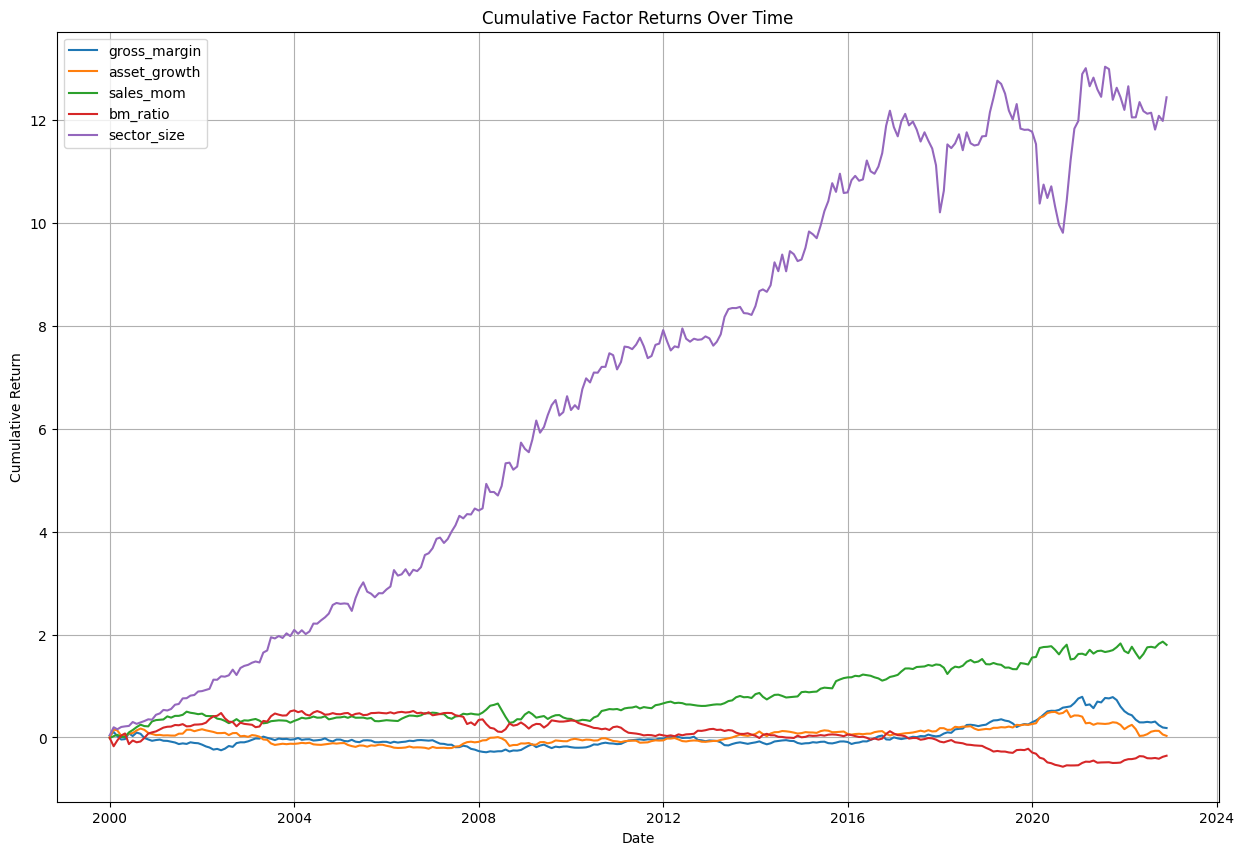

In [ ]:
plt.figure(figsize=(15, 10))

# rank in descending order
for factor in ['gross_margin', 'asset_growth', 'sales_mom', 'bm_ratio']:
    factor_return_df = calculate_factor_returns(merged_df, factor, ascending=False)
    factor_return_df['Cumulative_Return'] = (1 + factor_return_df[f'{factor}_Return']).cumprod() - 1
    plt.plot(factor_return_df['Date'], factor_return_df['Cumulative_Return'], label=f'{factor}')
    
# rank in ascending order
for factor in ['sector_size']:
    factor_return_df = calculate_factor_returns(merged_df, factor, ascending=True)
    factor_return_df['Cumulative_Return'] = (1 + factor_return_df[f'{factor}_Return']).cumprod() - 1
    plt.plot(factor_return_df['Date'], factor_return_df['Cumulative_Return'], label=f'{factor}')

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Factor Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()

#### 2.2 Fama-MacBeth Regression

In [21]:
ff5_df = pd.read_csv('data/F-F_Research_Data_5_Factors_2x3.csv', skiprows=3, header=0, skip_blank_lines=False)
empty_row_index = np.where(ff5_df.iloc[:, 0].isnull())[0][0]
ff5_df = ff5_df.iloc[:empty_row_index] 
ff5_df['Month'] = pd.to_datetime(ff5_df.iloc[:, 0], format='%Y%m')
ff5_df.drop(ff5_df.columns[0], axis=1, inplace=True)
ff5_df.loc[:, ff5_df.columns != 'Month'] = ff5_df.loc[:, ff5_df.columns != 'Month'].apply(pd.to_numeric, errors='coerce').astype(float)
ff5_df.loc[:, ff5_df.columns != 'Month'] = ff5_df.loc[:, ff5_df.columns != 'Month'] / 100
ff5_df.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF,Month
0,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027,1963-07-01
1,0.0507,-0.008,0.018,0.0036,-0.0035,0.0025,1963-08-01
2,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027,1963-09-01
3,0.0253,-0.0139,-0.001,0.028,-0.0201,0.0029,1963-10-01
4,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027,1963-11-01


In [40]:
def fama_macbeth_regression(stock_ret_df, factor_washed_df, ff5_df):
    # Ensure all columns used in regression are numeric
    stock_ret_df = stock_ret_df.apply(pd.to_numeric, errors='coerce')
    factor_washed_df = factor_washed_df.apply(pd.to_numeric, errors='coerce')
    ff5_df = ff5_df.apply(pd.to_numeric, errors='coerce')

    merged_df = pd.merge(stock_ret_df, factor_washed_df, left_on=['PERMNO', 'Month'], right_on=['LPERMNO', 'YearMonth'], how='inner')
    merged_df.drop(columns=['LPERMNO', 'Month'], inplace=True)
    merged_df = pd.merge(merged_df, ff5_df, left_on='YearMonth', right_on='Month', how='inner')
    merged_df.drop(columns=['Month'], inplace=True)
    all_factors = list(factor_washed_df.columns[2:]) + list(ff5_df.columns[:-1])

    # stage 1: time-series regression
    beta_dict = {}
    for permno, group in merged_df.groupby('PERMNO'):
        X = group[all_factors]
        X = sm.add_constant(X)
        y = group['MthRet']
        model = sm.OLS(y, X, missing='drop').fit()
        beta_dict[permno] = model.params[1:]

    beta_df = pd.DataFrame(beta_dict).T.reset_index().rename(columns={'index':'PERMNO'})
    beta_df = pd.merge(stock_ret_df, beta_df, on='PERMNO')

    # stage 2: cross-sectional regression
    lambda_lst = []
    for month, group in beta_df.groupby('YearMonth'):
        X = group[all_factors]
        X = sm.add_constant(X)
        y = group['MthRet']
        try:  # Ensure there is data to fit the model
            model = sm.OLS(y, X).fit()
            lambda_lst.append(model.params[1:])
        except:
            continue

    return lambda_lst

In [42]:
fama_macbeth_regression(stock_ret_df, factor_washed_df, ff5_df)

ValueError: zero-size array to reduction operation maximum which has no identity